In [158]:
import tensorflow as tf
import numpy as np
import os
import re
import csv
from IPython import display as ipythondisplay
from tqdm import tqdm
import nltk
from gensim.models import Word2Vec
from datetime import datetime
from keras.callbacks import EarlyStopping

nltk.download('stopwords')
from nltk.corpus import stopwords

print(tf.__version__)

2.7.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evely\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
STOPWORDS = set(stopwords.words('english'))

In [88]:
articles = []
labels = []
label_dict = {}
reverse_label_dict = {}

label_ind = 0
with open("../Data/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        if row[0] not in label_dict:
            label_dict[row[0]] = label_ind
            reverse_label_dict[label_ind] = row[0]
            label_ind += 1

        labels.append(label_dict[row[0]])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append([word for word in re.split(',|_|-|\!| |\.|\(|\)|\:|\?', article) if word != ''])

a = np.array(labels)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
labels = b

print(len(labels), labels[:10])
print(len(articles), articles[0])

2225 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
2225 ['tv', 'future', 'hands', 'viewers', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'digital', 'video', 'recorders', 'moving', 'living', 'room', 'way', 'people', 'watch', 'tv', 'radically', 'different', 'five', 'years', 'time', 'according', 'expert', 'panel', 'gathered', 'annual', 'consumer', 'electronics', 'show', 'las', 'vegas', 'discuss', 'new', 'technologies', 'impact', 'one', 'favourite', 'pastimes', 'us', 'leading', 'trend', 'programmes', 'content', 'delivered', 'viewers', 'via', 'home', 'networks', 'cable', 'satellite', 'telecoms', 'companies', 'broadband', 'service', 'providers', 'front', 'rooms', 'portable', 'devices', 'one', 'talked', 'about', 'technologies', 'ces', 'digital', 'personal', 'video', 'recorders', 'dvr', 'pvr', 'set', 'top', 'boxes', 'like', 'us', 'tivo'

In [89]:
WVmodel = Word2Vec(articles, min_count=1)
print(WVmodel)
words = list(WVmodel.wv.key_to_index.keys())
# print(words)
# print(WVmodel.wv['mr'])
# save model
print(WVmodel.vector_size)
WVmodel.save('model.bin')
# load model
# new_model = Word2Vec.load('model.bin')

Word2Vec(vocab=30495, vector_size=100, alpha=0.025)
100


In [90]:
vocab_size = len(WVmodel.wv)
embedding_dim = WVmodel.vector_size
max_length = 200
padding_value = np.zeros(embedding_dim)
training_portion = .8

In [91]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_sequences = [[WVmodel.wv[word] for word in article] for article in train_articles]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_sequences = [[WVmodel.wv[word] for word in article] for article in validation_articles]
validation_labels = labels[train_size:]

In [92]:
def pad(x, maxlen, value):
    new_x = np.array([np.array([value for w in range(maxlen)]) for a in x])
    for i in range(len(x)):
        if len(x[i]) <= maxlen:
            new_x[i, :len(x[i])] = np.array(x[i])
        else:
            new_x[i] = np.array(x[i][:maxlen])
    return new_x

In [93]:
train_padded = pad(train_sequences, maxlen=max_length, value=padding_value)
validation_padded = pad(validation_sequences, maxlen=max_length, value=padding_value)

In [94]:
def get_batch(articles, labels, batch_size):
    idx = np.random.choice(len(articles), batch_size)

    x_batch = np.array([articles[i] for i in idx])
    y_batch = np.array([labels[i] for i in idx])
  
    return x_batch, y_batch

In [95]:
def build_model(rnn_units, dense_units, output_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units)),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(output_units, activation='softmax')
    ])

    return model

In [130]:
def compute_loss(labels, y):
  loss = tf.keras.metrics.categorical_crossentropy(labels, y)
  return loss

In [139]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1
epsilon = 1e-3

# Model parameters
rnn_units = 1024
dense_units = 256
num_categories = len(labels[0])

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [140]:
model = build_model(rnn_units=rnn_units, dense_units=dense_units, output_units=num_categories)

In [166]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)

Epoch 1/10
56/56 [==============================] - 585s 10s/step - loss: 1.0145 - accuracy: 0.5989 - val_loss: 0.9231 - val_accuracy: 0.6494
Epoch 2/10
56/56 [==============================] - 573s 10s/step - loss: 0.8117 - accuracy: 0.6921 - val_loss: 0.7937 - val_accuracy: 0.6944
Epoch 3/10
56/56 [==============================] - 674s 12s/step - loss: 0.6702 - accuracy: 0.7478 - val_loss: 0.6392 - val_accuracy: 0.7753
Epoch 4/10
56/56 [==============================] - 635s 11s/step - loss: 0.5284 - accuracy: 0.8129 - val_loss: 0.6332 - val_accuracy: 0.7483
Epoch 5/10
56/56 [==============================] - 589s 11s/step - loss: 0.4743 - accuracy: 0.8421 - val_loss: 0.5677 - val_accuracy: 0.8067
Epoch 6/10
56/56 [==============================] - 454s 8s/step - loss: 0.4756 - accuracy: 0.8444 - val_loss: 0.5767 - val_accuracy: 0.8022
Epoch 7/10
56/56 [==============================] - 522s 9s/step - loss: 0.5275 - accuracy: 0.8236 - val_loss: 0.6946 - val_accuracy: 0.7618
Epoch 8/

In [167]:
model.save_weights(checkpoint_prefix + str(datetime.now().strftime("_%m-%d-%Y_%H-%M-%S")))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(x, y): 
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

In [148]:
history = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(train_padded, train_labels, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix + str(datetime.now().strftime("_%m-%d-%Y_%H-%M-%S")))

  0%|          | 2/2000 [00:09<2:45:50,  4.98s/it]

0.0


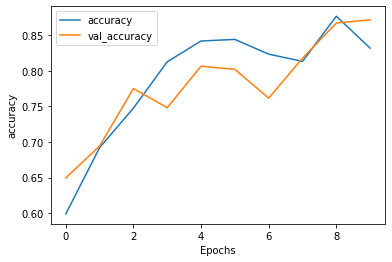

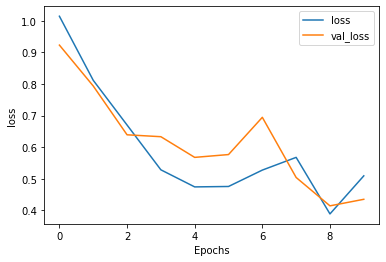

In [168]:
from matplotlib import pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss") 

In [209]:
# "journal entries"

tech1 = "Today I bought a new computer, after trying to download RAM on my old laptop and getting a virus. This new model has far more processing power, and a high definition screen. Because of how clear and bright this screen is, it will definitely be replacing my TV."
tech2 = "I tried the firefox browser this afternoon, and I think I won't be using google chrome any longer. The default search engine is much more accurate, and it is genuinely an inspiring piece of software. I still need to remove internet explorer from by desktop."
tech3 = "Sony just released the new ps5, but as a true gamer, I think I will stick to my xbox. Any gamer knows that playstations and PCs are inferior, and mobile games are unspeakable."

tech = [tech1, tech2, tech3]

sports1 = "I have been getting into football recently, chelsea is my favorite club. My friends prefer tennis or rugby. I might join a rookie football team one day in my local league."
sports2 = "My team lost the world cup. I am sad, but the true victory is the friends we made along the way."
sports3 = "chelsea made a brilliant defensive play in the last game. chelsea held most of possession in the second half, and claimed a clean victory."

sports = [sports1, sports2, sports3]

business1 = "Inflation in the US is causing major economic troubles. The value of the US dollar is at an all time low, and I am losing my life savings to the stock market."
business2 = "Major companies should give their employees more paid time off to see an increase in productivity and revenue."
business3 = "Can a bank declare bankruptcy? Do insurance companies go into debt?"

business = [business1, business2, business3]

politics1 = "Make sure to cast your votes on election day. The best candidate deserves to govern."
politics2 = "Political parties make voting options slim. Why do we all need to vote for the big guy to be useful to the election?"
politics3 = "Polls say citizens do not want to vote for government officials who start cover up wars."

politics = [politics1, politics2, politics3]

entertainment1 = "A new movie is premiering tomorrow starring hollywood actor kevin bacon. The production company is hoping for high ratings and high box office sales."
entertainment2 = "New rap albums are being released this week. Rap is my favorite genre of music, and should be highlighted more at the grammys. My favorite artist got 10 nominations last year."
entertainment3 = "2D animation is much more impressive and artistic than 3D animation. I miss the days of 2D cartoons being the majority of kids shows."

entertainment = [entertainment1, entertainment2, entertainment3]

In [210]:
model = build_model(rnn_units=rnn_units, dense_units=dense_units, output_units=num_categories)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [211]:
def w2v(sentences):
    processed_sentences = []
    for s in sentences:
        for word in STOPWORDS:
            token = ' ' + word + ' '
            s = s.replace(token, ' ')
            s = s.replace(' ', ' ')
        processed_sentences.append([word for word in re.split(',|_|-|\!| |\.|\(|\)|\:|\?', s) if word != ''])

    w2v = [[WVmodel.wv[word] if word in words else padding_value for word in sentence] for sentence in processed_sentences]
    return pad(w2v, maxlen=max_length, value=padding_value)

def run_model(categoryW2V):
    res = []
    for sentence in categoryW2V:
        y = model(np.array([sentence]))
        res.append(y)

    print(res)
    return res

techRes = run_model(w2v(tech))
sportsRes = run_model(w2v(sports))
businessRes = run_model(w2v(business))
politicsRes = run_model(w2v(politics))
entertainmentRes = run_model(w2v(entertainment))

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.47330266, 0.09498239, 0.00434075, 0.41458422, 0.01279001]],
      dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.36646235, 0.05269684, 0.00899765, 0.5606835 , 0.01115972]],
      dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.0977043 , 0.09743942, 0.0353365 , 0.7593432 , 0.01017656]],
      dtype=float32)>]
[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.00185033, 0.00116574, 0.84099644, 0.15350957, 0.00247803]],
      dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.00139046, 0.00143031, 0.7903514 , 0.20475093, 0.00207696]],
      dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[5.2713882e-04, 3.6670733e-04, 9.1295314e-01, 8.5058801e-02,
        1.0941519e-03]], dtype=float32)>]
[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.04972943, 0.5057112 , 0.04109954, 0.3810376 , 0.02242229]],
      dtype=floa

In [212]:
entry_dict = {}
category_list = ["tech", "sports", "business", "politics", "entertainment"]
for i in range(15):
    entry_dict[i] = category_list[i//3] + str(i % 3 + 1)

In [213]:
results = techRes + sportsRes + businessRes + politicsRes + entertainmentRes

def test_model(test_ind):
    cur = np.array(results[test_ind][0])

    most_sim_ind = None
    similarity = None

    for i in range(len(results)):
        if i == test_ind:
            continue
        comp = np.array(results[i][0])
        dist = np.linalg.norm(cur - comp)
        if similarity == None or dist < similarity:
            most_sim_ind = i
            similarity = dist

    print("The most similar entry to " + entry_dict[test_ind] + " is " + entry_dict[most_sim_ind])

for i in range(len(results)):
    test_model(i)

The most similar entry to tech1 is tech2
The most similar entry to tech2 is tech1
The most similar entry to tech3 is business2
The most similar entry to sports1 is sports2
The most similar entry to sports2 is sports1
The most similar entry to sports3 is sports1
The most similar entry to business1 is entertainment1
The most similar entry to business2 is tech3
The most similar entry to business3 is tech3
The most similar entry to politics1 is politics2
The most similar entry to politics2 is politics3
The most similar entry to politics3 is politics2
The most similar entry to entertainment1 is business3
The most similar entry to entertainment2 is entertainment3
The most similar entry to entertainment3 is entertainment2
